In [36]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [37]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [38]:
import tensorflow as tf
from tensorflow import keras

In [39]:
modeloBasePath='modelos/modeloGeneral_completo/vanilla_NO_dropout.h5'
modeloSave='/transfer_vanilla_dropout.h5'

In [40]:
balanceo=''

In [41]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

In [42]:
paciente='paciente2'

In [43]:
with open('dataset/generado/'+paciente+'/array_Xtrain'+balanceo+'.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [44]:
len(array_Xtrain)

13931

In [45]:
with open('dataset/generado/'+paciente+'/array_Ytrain'+balanceo+'.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [46]:
len(array_Ytrain)

13931

In [47]:
with open('dataset/generado/'+paciente+'/array_Xval'+balanceo+'.npy', 'rb') as f:
    array_Xval = np.load(f)

In [48]:
len(array_Xval)

1741

In [49]:
with open('dataset/generado/'+paciente+'/array_Yval'+balanceo+'.npy', 'rb') as f:
    array_Yval = np.load(f)

In [50]:
len(array_Yval)

1741

In [51]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [52]:
len(array_Xtest)

1742

In [53]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [54]:
len(array_Ytest)

1742

In [55]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [56]:
base_model = keras.models.load_model(modeloBasePath)

55/55 [==============================] - 1s 11ms/step


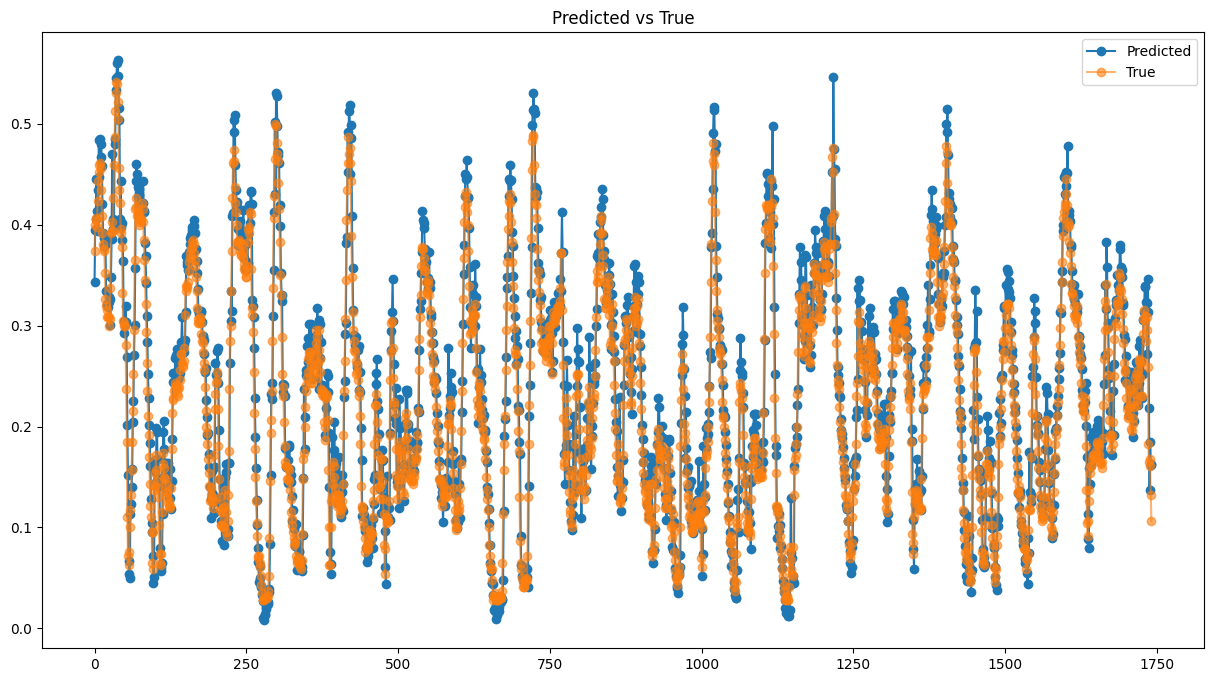

In [57]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [58]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.02396962898557865,
 'mse': 0.030767406817253345,
 'rmse': 0.0009466333222583676}

# Iniciamos transfer learning

In [59]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


In [60]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_4')>

In [61]:
transferModel=model_LSTM.transferLearning_NewModel(base_model,-2,True)
transferModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 newLayer (Dense)            (None, 32)                1056      
                                                                 
 newDropout (Dropout)        (None, 32)                0         
                                                                 
 newOutput (Dense)           (None, 1)                 33  

In [62]:
array_Xtrain.shape

(13931, 30, 5)

In [63]:
transferModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =transferModel.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
transferModel.save('modelos/'+paciente+modeloSave)

Epoch 1/100
436/436 [==============================] - 10s 14ms/step - loss: 0.0084 - mae: 0.0552 - mse: 0.0084 - val_loss: 7.9116e-04 - val_mae: 0.0216 - val_mse: 7.9116e-04
Epoch 2/100
436/436 [==============================] - 7s 16ms/step - loss: 0.0022 - mae: 0.0324 - mse: 0.0022 - val_loss: 7.2705e-04 - val_mae: 0.0205 - val_mse: 7.2705e-04
Epoch 3/100
436/436 [==============================] - 7s 16ms/step - loss: 0.0014 - mae: 0.0253 - mse: 0.0014 - val_loss: 6.5310e-04 - val_mae: 0.0188 - val_mse: 6.5310e-04
Epoch 4/100
436/436 [==============================] - 7s 15ms/step - loss: 0.0010 - mae: 0.0211 - mse: 0.0010 - val_loss: 6.5874e-04 - val_mae: 0.0191 - val_mse: 6.5874e-04
Epoch 5/100
436/436 [==============================] - 6s 15ms/step - loss: 8.4584e-04 - mae: 0.0191 - mse: 8.4584e-04 - val_loss: 6.9624e-04 - val_mae: 0.0196 - val_mse: 6.9624e-04
Epoch 6/100
436/436 [==============================] - 5s 12ms/step - loss: 7.6239e-04 - mae: 0.0184 - mse: 7.6239e-04 - 

55/55 [==============================] - 0s 7ms/step - loss: 6.9348e-04 - mae: 0.0199 - mse: 6.9348e-04
test loss, test acc: [0.000693482521455735, 0.019894694909453392, 0.000693482521455735]


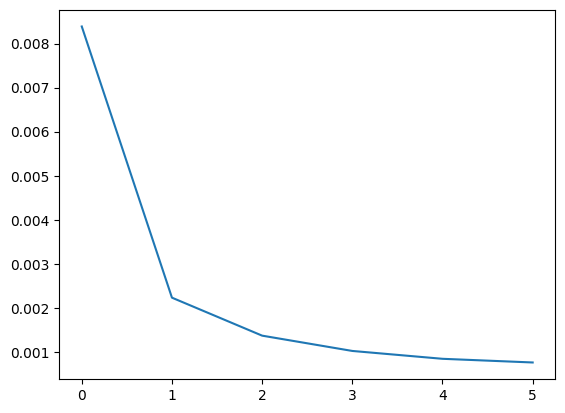

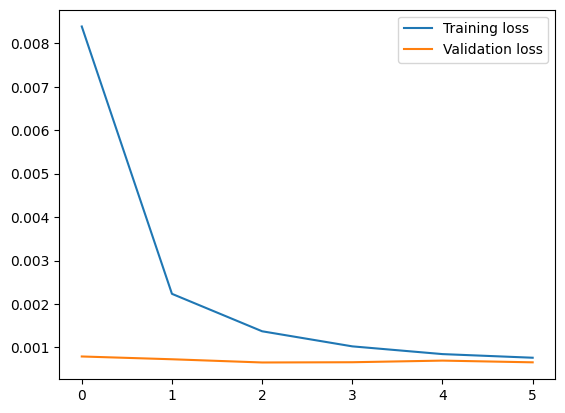

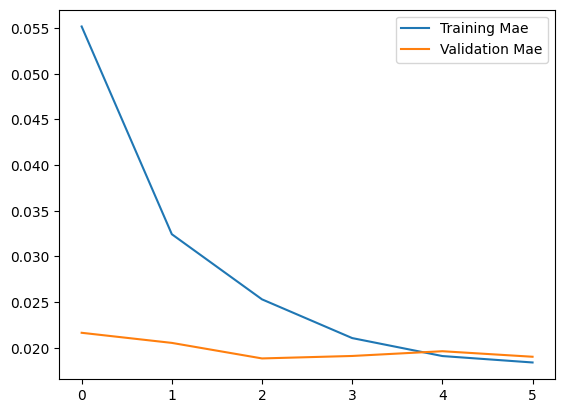

In [64]:
model_utils.modelEvaluateTraining(transferModel,history,array_Xtest, array_Ytest)

55/55 [==============================] - 1s 5ms/step


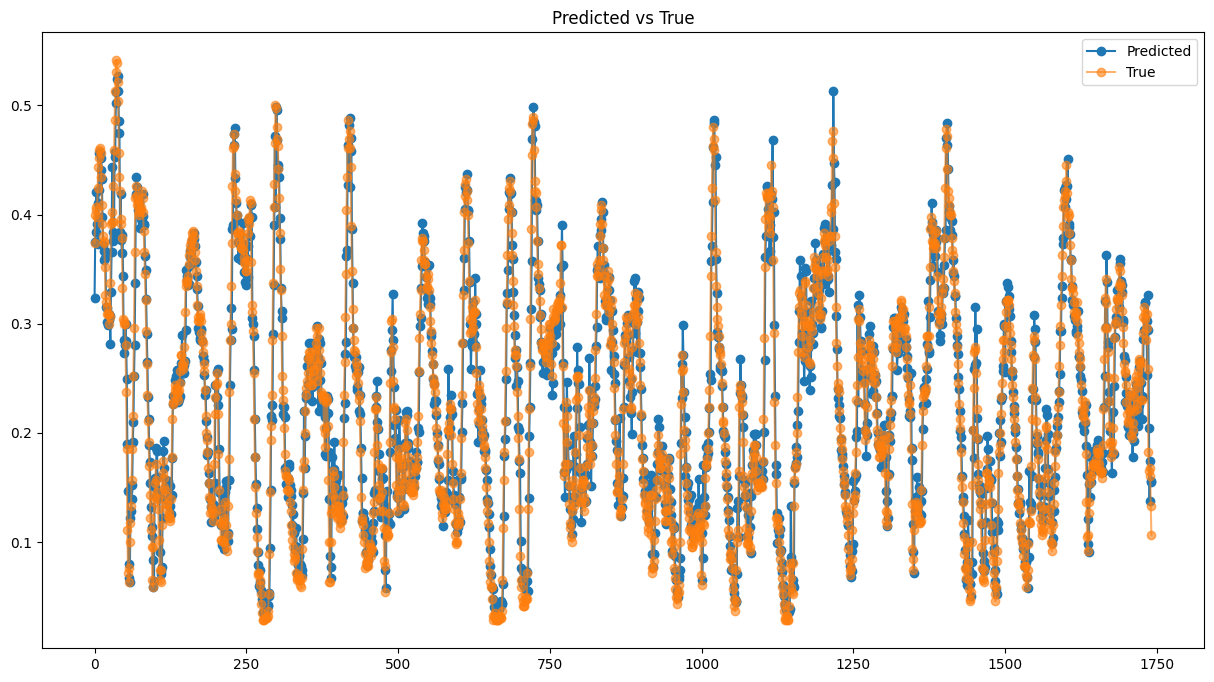

In [65]:
yhat = transferModel.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [66]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.01989469648761304,
 'mse': 0.026334054159643384,
 'rmse': 0.000693482408483031}

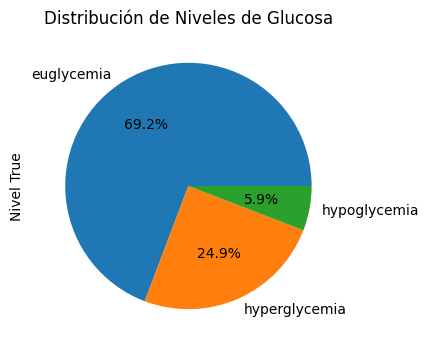

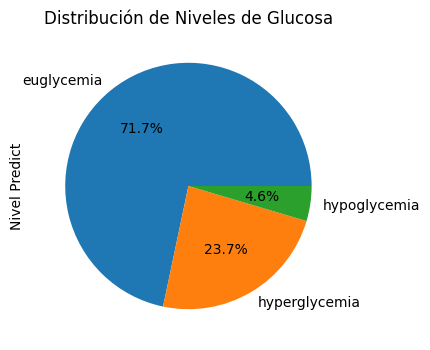

,Glucose level True,Nivel True,Glucose level Predict,Nivel Predict
0,212.0,hyperglycemia,188.863174,hyperglycemia
1,224.0,hyperglycemia,212.246414,hyperglycemia
2,226.0,hyperglycemia,216.505142,hyperglycemia
3,227.0,hyperglycemia,233.581253,hyperglycemia
4,223.0,hyperglycemia,219.961899,hyperglycemia


In [67]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


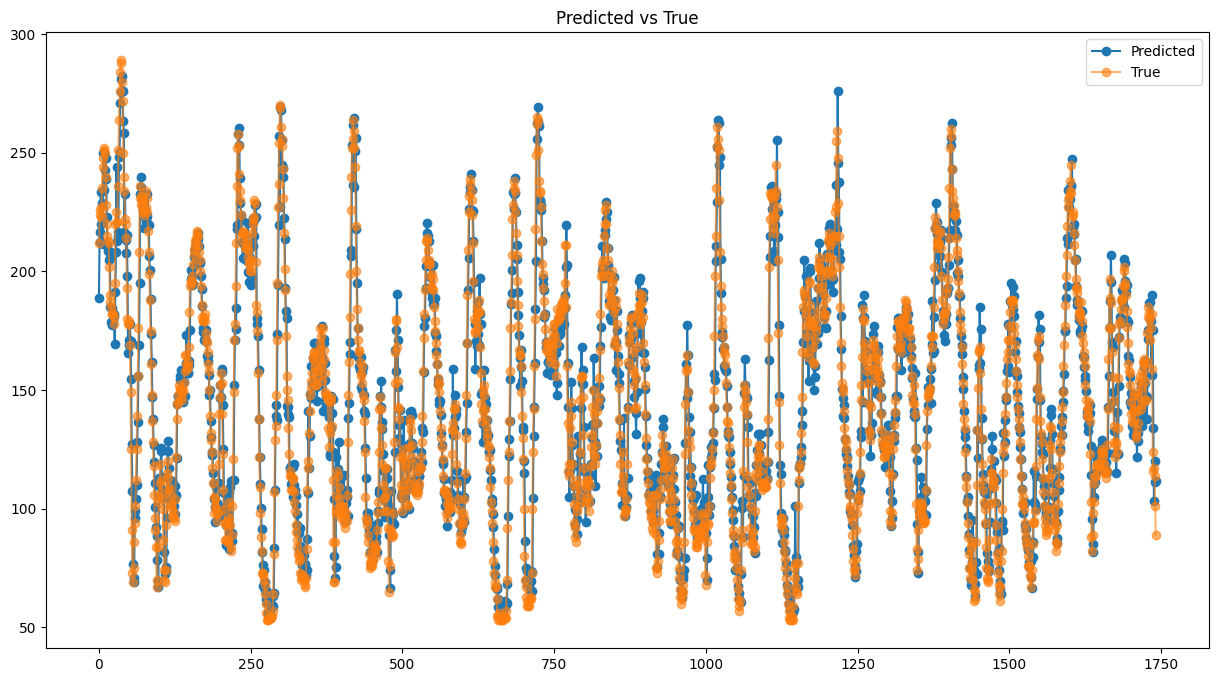

{'mae': 9.151559947087215,
 'mse': 12.113664533752159,
 'rmse': 146.74086843628493}

In [68]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [69]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

,y_true,y_pred
2023-01-01 00:00:00,212.0,188.863174
2023-01-01 00:15:00,224.0,212.246414
2023-01-01 00:30:00,226.0,216.505142
2023-01-01 00:45:00,227.0,233.581253
2023-01-01 01:00:00,223.0,219.961899
...,...,...
2023-01-19 02:15:00,116.0,133.911621
2023-01-19 02:30:00,117.0,103.253372
2023-01-19 02:45:00,114.0,120.011887
2023-01-19 03:00:00,101.0,111.389900


AP, BE, EP: (0.9586444572085009, 0.032165422171166, 0.009190120620333142)


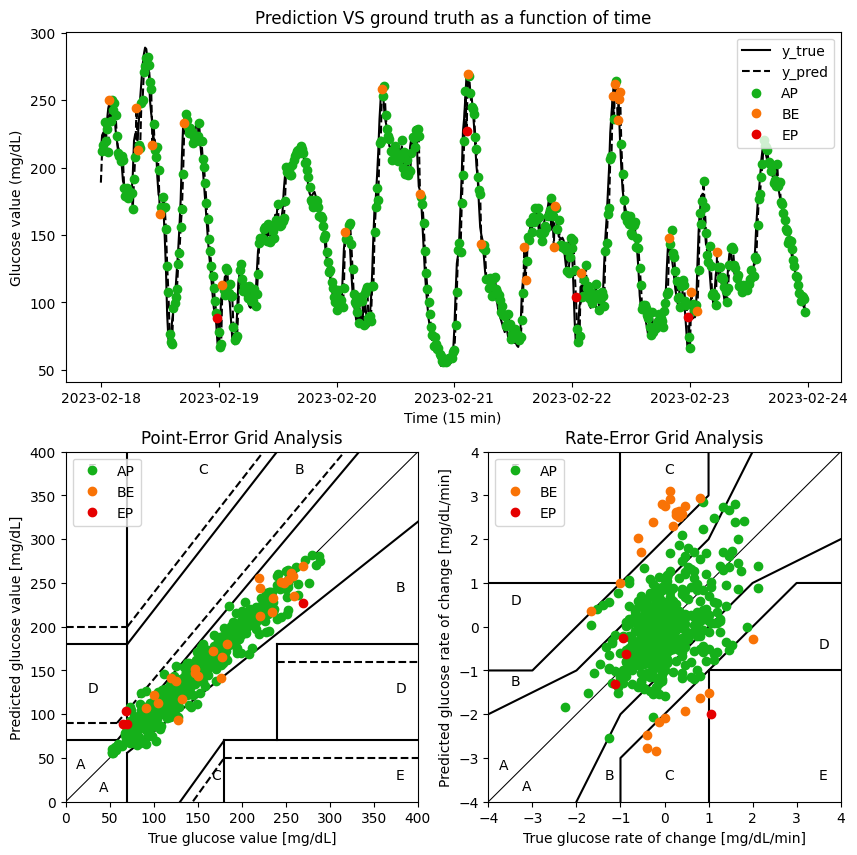

In [70]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)